In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [44]:
def HPD_gamma(n,ybar,guesses,C,niter=20):
    """
    This function is used to find a HPD Region for an Exponential Rate.
    
    In the case of Exponential Rate, Posterior probability is Gamma Density.
    
    To find an HPD Region, we are going to use following algorithm.
    
    Choose a value of K to get theta0 and theta1,
    Use newton method to solve the equation p(theta|y) =k, for its two solution.
    Evaluate  prob = p(theta < theta0|y) + p(theta > theta1|y)
    
    if prob is close to 0.05, then stop and use (theta0, theta1) as the HPD Region.
    otherwise repeat the step with different guess.
    
    gamma uses rate parameterization. 
    
    """
    from math import gamma,lgamma, log
    from scipy.stats import gamma
    
    
    alpha = n
    beta = n*ybar
    con = alpha*log(beta)-lgamma(alpha)-log(C) # Constant here C is same as K
    
    theta0 = guesses[0]
    theta1 = guesses[1]
    
    for i in range(0,niter):
        theta0=theta0-(con+(alpha-1)*log(theta0)-beta*theta0)/((alpha-1)/theta0-beta)
        
        theta1=theta1-(con+(alpha-1)*log(theta1)-beta*theta1)/((alpha-1)/theta1-beta)
        
    
    p1 = gamma.cdf(x=theta0,a=alpha,scale = 1/beta)
    p2 = 1 - gamma.cdf(x= theta1,a=alpha,scale = 1/beta)
    return [theta0,theta1,p1,p2,p1+p2]

In [45]:
HPD_gamma(50,756.3,[0.001,0.0017],500)

[0.0010047250398282123,
 0.0016382592721619624,
 0.035255822283253357,
 0.052846296044812391,
 0.088102118328065748]

In [37]:
HPD_gamma(50,756.3,[0.001,0.0017],200)

[0.0009330382513331387,
 0.0017421978192361319,
 0.011261385068757099,
 0.018291747709398787,
 0.029553132778155886]

In [43]:
HPD_gamma(50,756.3,[0.001,0.0017],313.5)

[0.0009655949278231253,
 0.0016938235408311105,
 0.0195218153577458,
 0.030546387120285234,
 0.050068202478031038]

In [32]:
gamma.cdf(x=3,a=2,loc=0,scale=1)

0.80085172652854419

In [49]:
gamma.rvs(a=50,scale=1/37815,size=100000)

array([ 0.00149764,  0.00184344,  0.00101873, ...,  0.00112652,
        0.00115368,  0.00157137])

In [50]:
theta = gamma.rvs(a=50,scale=1/37815,size=100000)
beta = 1 /theta

In [51]:
beta.mean()

772.00229537324799

In [52]:
beta.std()

111.96168900992531

In [54]:
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)


def kde_statsmodels_u(x, x_grid, bandwidth=0.2, **kwargs):
    """Univariate Kernel Density Estimation with Statsmodels"""
    kde = KDEUnivariate(x)
    kde.fit(bw=bandwidth, **kwargs)
    return kde.evaluate(x_grid)
    
    
def kde_statsmodels_m(x, x_grid, bandwidth=0.2, **kwargs):
    """Multivariate Kernel Density Estimation with Statsmodels"""
    kde = KDEMultivariate(x, bw=bandwidth * np.ones_like(x),
                          var_type='c', **kwargs)
    return kde.pdf(x_grid)


def kde_sklearn(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scikit-learn"""
    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(x[:, np.newaxis])
    # score_samples() returns the log-likelihood of the samples
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis])
    return np.exp(log_pdf)

In [55]:
kde_funcs = [kde_statsmodels_u, kde_statsmodels_m, kde_scipy, kde_sklearn]
kde_funcnames = ['Statsmodels-U', 'Statsmodels-M', 'Scipy', 'Scikit-learn']

0
1
2
3


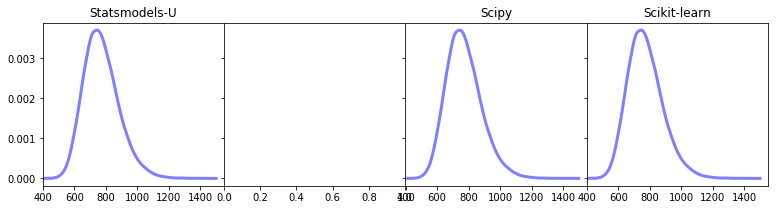

In [59]:
fig, ax = plt.subplots(1, 4, sharey=True,
                       figsize=(13, 3))
fig.subplots_adjust(wspace=0)
x_grid = np.linspace(400, 1500, 1000)
x = beta
for i in range(4):
    print(i)
    try:
        pdf = kde_funcs[i](x, x_grid, bandwidth=15)
        ax[i].plot(x_grid, pdf, color='blue', alpha=0.5, lw=3)
        #ax[i].fill(x_grid, pdf_true, ec='gray', fc='gray', alpha=0.4)
        ax[i].set_title(kde_funcnames[i])
        ax[i].set_xlim(398, 1550)
    except:
        pass
plt.show()